# Fixed Effect Estimation - Visual Primer

Fixed effects are a very common technique used in estimation to control for unobserved variation across groups.  This is all well and good in the abstract, but sometimes seeing the operation explicitly helps to solidify intuition.  The purpose of this Notebook is to provide a ready-made product for just this purpose.

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

%pylab inline

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

Populating the interactive namespace from numpy and matplotlib


## The Role of the Intercept

The common need for a constant term is generally established early on in econometrics, but its purpose is sometimes glossed over.  It is worth rehashing here since fixed effects are inextricably linked to this constant term.  Consider the following regression equation:

$$y = \beta_0 + \sum_{i=1}^p X_i \beta_i + \epsilon$$

The constant term, $\beta_0$, appears to sit alone.  In reality, it is one element of a product, just like all of the other $\beta_i$.  Instead of $X_i$, its counterpart is the scalar value $X_0=1$.  The value of $X_0$ is the same for all observations.  The implication is that all observations have some common starting place, and then the values of the other regressors deflect them from that position.  In other words, the values of the other regressors are simply leading to deviations from the average value.

Let's simulate some data and take a look at what this means in practice.  The data will be simulated according to the following model:

$$y = 10 + 2X_1$$

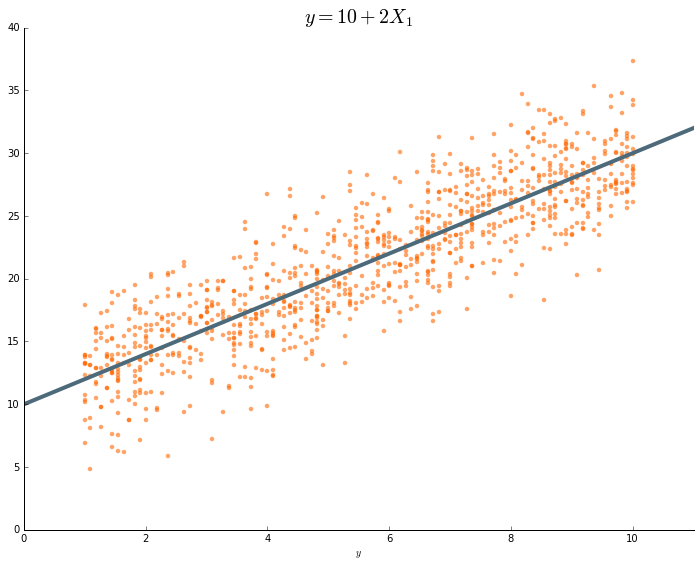

In [27]:
#Set number of observations
n=1000

#Generate regressor data
x1=np.random.choice(np.linspace(1,10,100),size=n)

#Generate error term
e=3*np.random.normal(size=n)

#Generate response data
y=10+2*x1+e

#Generate plot object
fig,ax=plt.subplots(figsize=(12,9))

#Plot data
ax.scatter(x1,y,c='#ff6600',lw=0,alpha=.6)

#Add underlying model line
ax.plot((0,11),(10,32),color='#4D6A7B',lw=4)

#Fix labels
ax.set_title('$y=10+2X_1$',fontsize=20)
ax.set_xlabel('$X_1$')
ax.set_xlabel('$y$')

#Fix axes
simpleaxis(ax)
ax.set_xlim(0,11);

As can be seen, the graph includes a line showing the underlying data generating process, which we know because we defined it.  Note the role of the intercept.  It captures the average value for all observations *before the regressor is taken into account*.  It captures an offset that enables us to minimize the variance around our coefficient estimate.  Sampling variation aside, we should see a strong overlap between the DGP line (which we defined), and the *linear* best fit line based on the data alone.

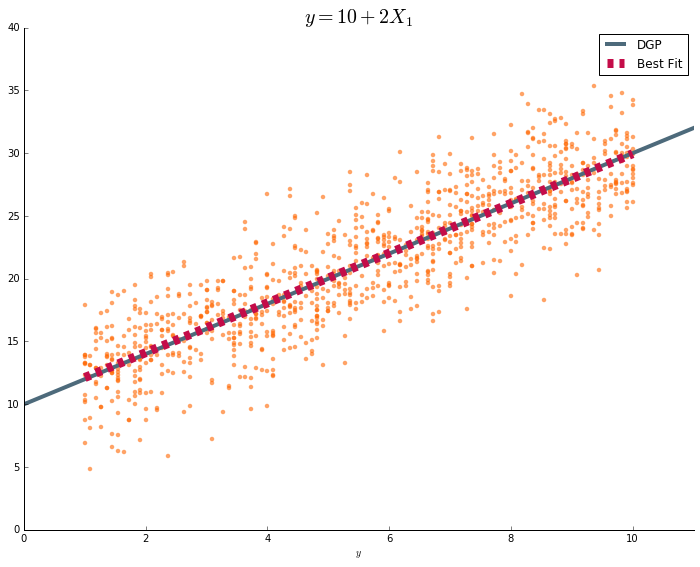

In [41]:
#Capture the slope and intercept for the best fit line
m,b=np.polyfit(x1,y,1)

#Capture the values associated slope (m) and intercept (b) along the support in the data
x1_support=sorted(set(x1))
best_fit_y=[]
for supp_val in x1_support:
    best_fit_y.append(m*supp_val+b)
    
#Generate plot object
fig,ax=plt.subplots(figsize=(12,9))
    
#Plot data
ax.scatter(x1,y,c='#ff6600',lw=0,alpha=.6)

#Add underlying model line
ax.plot((0,11),(10,32),color='#4D6A7B',lw=4,label='DGP')

#Add best fit line
ax.plot(x1_support,best_fit_y,c='#C40C49',lw=9,linestyle='--',label='Best Fit')

#Fix labels
ax.set_title('$y=10+2X_1$',fontsize=20)
ax.set_xlabel('$X_1$')
ax.set_xlabel('$y$')
ax.legend(loc='best')

#Fix axes
simpleaxis(ax)
ax.set_xlim(0,11);

Confirmed.  Note that for linear models, this is essentially what we are doing (coming up with best fit lines).  If we were to omit the constant term in a linear model, however, it would be the same as saying that our best fit line must start at the origin.  In other words, we would have removed the offset.  

Can we come up with a best fit line that starts at the origin?  This is actually somewhat non-standard, so I am not aware of an off the shelf method.  Since the computational requirements are low, we will brute force this guy.  We will generate a whole mess of lines by varying the slope ($m$) and keeping the intercept at the origin.  With these lines, we can determine the value of the least-squares loss function, and choose the slope with the smallest value.

Here are the lines associated with a bunch of slopes.

(0, 40)

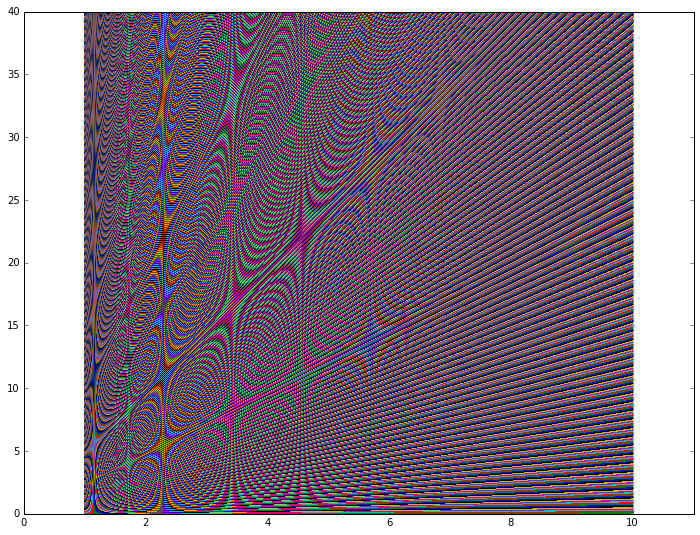

In [68]:
#Identify number of slopes to evaluate
n_m=10000

#Generate slope values
m_vals=np.linspace(0,100,n_m)

#Create a container lines associated with each slope
m_lines=[]

#For each slope...
for mv in m_vals:
    #...create a container for the points associated with that slope...
    mv_line=[]
    #...and for each support point...
    for supp_val in x1:#_support:
        #...capture the y-values associated with the slope in that position (w/o intercept)
        mv_line.append(mv*supp_val)
    #...and throw the line in m_lines
    m_lines.append(mv_line)
    
#Generate plot object
fig,ax=plt.subplots(figsize=(12,9))

#For each line in m_lines...
for l in m_lines:
    #...plot that line
#     ax.plot(x1_support,l)
    ax.plot(x1,l)

ax.set_xlim(0,11)
ax.set_ylim(0,40)

We are using a least squares loss function, so we just need to choose the one that minimizes the sum of squared deviations between a given line and the data.

$$\text{min}(\sum_{i=1}^n (y_i - y_m)^2)$$

where $y_m$ is just the value of $y$ for the line of slope $m$.  The comparison $(y_i - y_m)$ is made at every support point in `x1_support`.  Let's capture all of these loss function values.

In [72]:
def ls_loss(l1,l2):
    '''Function returns the sum of squared deviations between the data and the given line'''
    if not len(l1)==len(l2):
        print 'Lines are of unequal length'
        return
    else:
        #Generate sum variable
        sum_squares=0
        #For each value of x...
        for i in range(len(l1)):
            #...capture the difference between the data and the line of slope m...
            dev=l1[i]-l2[i]
            #...and add the squared deviation to sum_squares...
            sum_squares+=dev**2
        return sum_squares
    
#Create container to hold all squared deviations
ss_list=[]
    
#For each line...
for ml in m_lines:
    #...capture the sum of squared deviations...
    ss=ls_loss(y,ml)
    #...and throw it in ss_list
    ss_list.append(ss)

Which value of $m$ corresponds to the minimum sum of squares?  How does it compare to our earlier best fit line?

First we need to capture the line from the origin and calculate the sum of squares for the earlier best fit line.

In [87]:
#Capture min sum squared
min_ss=[(i,val) for (i,val) in enumerate(ss_list) if val==min(ss_list)]

#Capture corresponding value of m
min_m=m_vals[min_ss[0][0]]

#Create a container for the points associated with min ss slope...
line_00=[]
#For each support point...
for supp_val in x1_support:
    #...capture the y-values associated with the slope in that position (w/o intercept)
    line_00.append(min_m*supp_val)
    
#Capture best fit line across all values of x1
best_fit_y_tot=[]
for supp_val in x1:
    best_fit_y_tot.append(m*supp_val+b)
    
#Capture sum of squares for best fit line
best_fit_ss=ls_loss(y,best_fit_y_tot)

What does it look like?

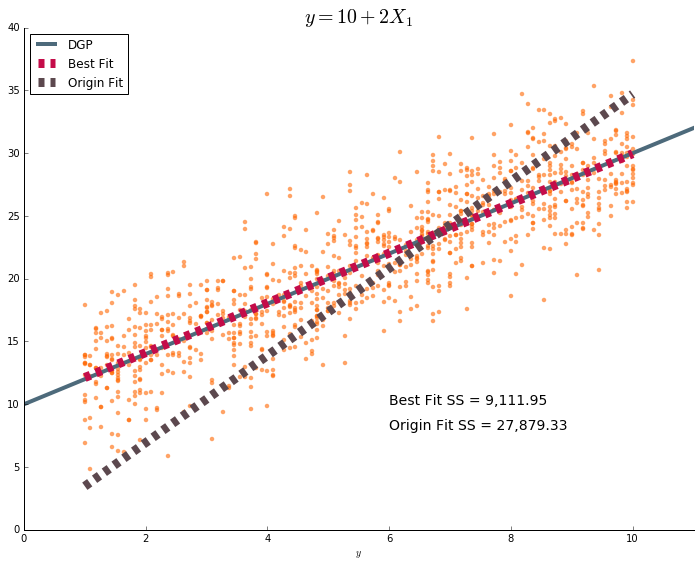

In [99]:
#Generate plot object
fig,ax=plt.subplots(figsize=(12,9))
    
#Plot data
ax.scatter(x1,y,c='#ff6600',lw=0,alpha=.6)

#Add underlying model line
ax.plot((0,11),(10,32),color='#4D6A7B',lw=4,label='DGP')

#Add best fit line
ax.plot(x1_support,best_fit_y,c='#C40C49',lw=9,linestyle='--',label='Best Fit')

#Add line from origin
ax.plot(x1_support,line_00,c='#5C484E',lw=9,linestyle='--',label='Origin Fit')

#Fix labels
ax.set_title('$y=10+2X_1$',fontsize=20)
ax.set_xlabel('$X_1$')
ax.set_xlabel('$y$')
ax.legend(loc='best')
ax.annotate('Best Fit SS = '+str('{:,.2f}'.format(best_fit_ss)),xy=(6,10),fontsize=14)
ax.annotate('Origin Fit SS = '+str('{:,.2f}'.format(min_ss[0][1])),xy=(6,8),fontsize=14)

#Fix axes
simpleaxis(ax)
ax.set_xlim(0,11);

As expected, the intercept improves the fit dramatically.

## Fixed Effects

Why the perhaps overly elaborate exposition on the constant term you ask?  Wait for it...

The constant term essentially *is a fixed effect*.  It is a component of variation that we don't really address in the model via the regressors.  One way to think about how it is different from the technique more commonly known as fixed effect estimation is that the intercept applies to all observations.  It is a fixed effect applied to the entire population.  FE estimation, however, modifies the intercept based upon the subgroup in which the observation is contained.  Consider the following model.

$$y = \beta_0 + \sum_{i=1}^p X_i \beta_i + \gamma\delta_j + \epsilon$$

where $\delta$ is the fixed effect and $\gamma$ is the coefficient associated with it.  There are $j$ subgroups in our data (e.g. states of residence).  Since fixed effects are scalar adjustments, this equation can really be thought of as the following:

$$y = \underbrace{(\beta_0 + \gamma\delta_j)}_{\text{intercept}_j} + \sum_{i=1}^p X_i \beta_i + \epsilon$$